In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from grr.cell_class import Cell
from LatencyModel import OhmicLatencyModel, IALatencyModel

In [2]:
RAW_DATA_PATH = os.path.join('..', '..', 'data', 'raw', '5HT', 'spk_time')
fnames = pd.read_csv(os.path.join(RAW_DATA_PATH, 'index.csv'))
fnames.head()

,Cell,PE,4AP,Recording
0,DRN347,0,0,18706000.abf
1,DRN347,0,0,18706001.abf
2,DRN347,0,0,18706002.abf
3,DRN347,0,0,18706003.abf
4,DRN347,0,0,18706004.abf


Include only recordings with no drugs (phenylephrine or 4AP) in the bath.

In [3]:
ctrl_fnames = fnames.loc[np.logical_and(fnames['PE'] == 0, fnames['4AP'] == 0), ['Cell', 'Recording']].reset_index(drop=True)
ctrl_fnames.head()

,Cell,Recording
0,DRN347,18706000.abf
1,DRN347,18706001.abf
2,DRN347,18706002.abf
3,DRN347,18706003.abf
4,DRN347,18706004.abf


In [4]:
cells = []
for cell_name in ctrl_fnames['Cell'].unique():
    rec_names = ctrl_fnames.loc[ctrl_fnames['Cell'] == cell_name, 'Recording']
    recs = Cell().read_ABF([os.path.join(RAW_DATA_PATH, fname) for fname in rec_names])
    for rec in recs:
        rec.set_dt(0.1)
    cells.append(recs)
del cell_name, rec_names, recs, rec

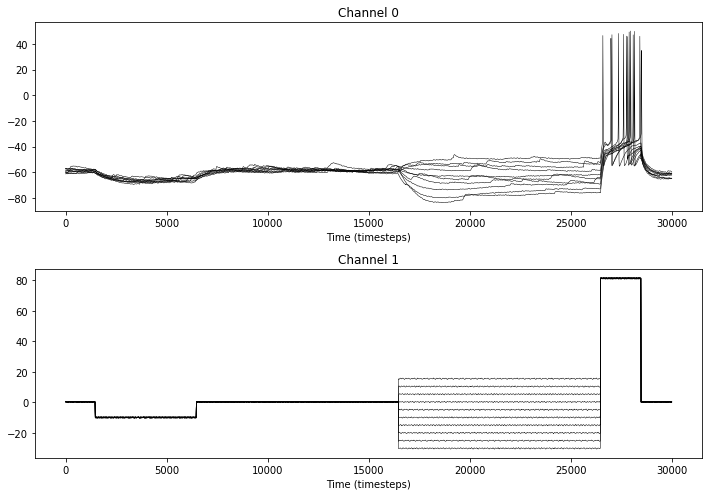

In [5]:
ex_cell = cells[0]
ex_cell[0].plot()

In [6]:
ohmic_pred = OhmicLatencyModel(0.1)
ohmic_pred.add_recordings(ex_cell, (0, 100), (5000, 5100), tau=(1000, 1700, 2700))
ohmic_pred.scrape_data(exclude_above=0)
ohmic_pred.fit(
    np.linspace(-50, 0, 20), 
    np.linspace(ohmic_pred.Vin_raw.mean() - 10, ohmic_pred.Vin_raw.mean() + 10, 20), 
    verbose=True
)

IA_pred = IALatencyModel(0.1)
IA_pred.add_recordings(ex_cell, (0, 100), (5000, 5100), tau=(1000, 1700, 2700))
IA_pred.scrape_data(exclude_above=0)
IA_pred.fit(
    np.linspace(-50, 0, 20), 
    np.linspace(ohmic_pred.Vin_raw.mean() - 10, ohmic_pred.Vin_raw.mean() + 10, 20),
    np.linspace(1, 20, 5),
    np.linspace(0.5, 2, 5),
    verbose=True
)

Fitting 100.0%    


In [9]:
print(' --- Ohmic model ---')
print(ohmic_pred)

print('\n --- IA model ---')
print(IA_pred)

 --- Ohmic model ---
tau_raw     :    85.152 None
Rin_raw     :   657.989 None
V0_raw      :   -61.453 None
Vin_raw     :    -4.569 None
tau_est     :   287.844 None
Vin_est     :   -14.569 None
thresh_est  :   -47.368 None

 --- IA model ---
tau_raw     :    85.152 None
Rin_raw     :   657.989 None
V0_raw      :   -61.453 None
Vin_raw     :    -4.569 None
tau_est     :    10.826 None
Vin_est     :   -14.569 None
thresh_est  :   -50.000 None
ga_est      :     1.000 None
tauh_est    :     0.500 None


Estimated OhmicLatencyModel parameters
Model tau   :   279.351 ms
Model tau: 279.4ms
Trace tau: 85.2ms
thresh: -46.9mV
Model V_in: -14.6.mV

Estimated IALatencyModel parameters
Model tau: 10.8ms
Trace tau: 85.2ms
thresh: -50.0mV
Model V_in: -14.6.mV
Trace V_in: {:.1f}
ga: 1.0
tauh: 0.5


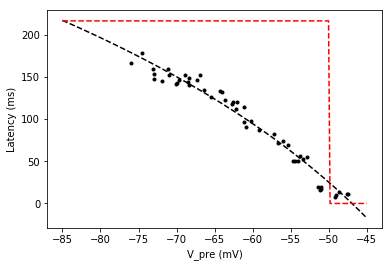

In [17]:
V0_vec = np.linspace(-85, -45, 200)

print('Estimated OhmicLatencyModel parameters')
print(param_str('Model tau', ohmic_pred.tau_est, 'ms'))
print('Model tau: {:.1f}ms'.format(ohmic_pred.tau_est))
print('Trace tau: {:.1f}ms'.format(ohmic_pred.tau_raw.mean()))
print('thresh: {:.1f}mV'.format(ohmic_pred.thresh_est))
print('Model V_in: {:.1f}.mV'.format(ohmic_pred.Vin_est))
print('')
print('Estimated IALatencyModel parameters')
print('Model tau: {:.1f}ms'.format(IA_pred.tau_est))
print('Trace tau: {:.1f}ms'.format(IA_pred.tau_raw.mean()))
print('thresh: {:.1f}mV'.format(IA_pred.thresh_est))
print('Model V_in: {:.1f}.mV'.format(IA_pred.Vin_est))
print('Trace V_in: {:.1f}')
print('ga: {:.1f}'.format(IA_pred.ga_est))
print('tauh: {:.1f}'.format(IA_pred.tauh_est))

plt.figure()

plt.subplot(111)
plt.plot(ohmic_pred.V0_raw, ohmic_pred.spks_raw, 'k.')
plt.plot(V0_vec, ohmic_pred.predict(V0=V0_vec, Vin=ohmic_pred.Vin_est), 'k--')
plt.plot(V0_vec, IA_pred.predict(V0=V0_vec, Vin=IA_pred.Vin_est, max_time=20.), 'r--')
plt.xlabel('V_pre (mV)')
plt.ylabel('Latency (ms)')

plt.show()

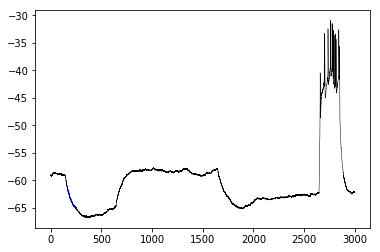

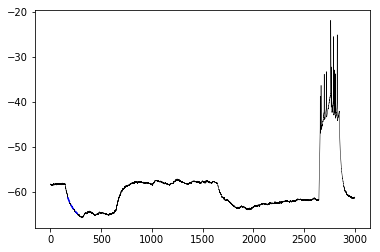

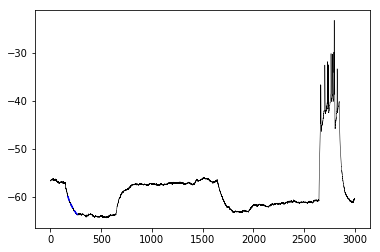

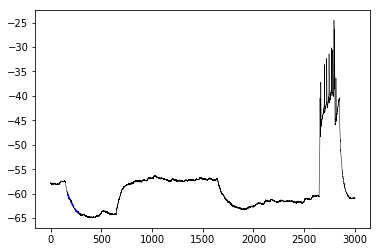

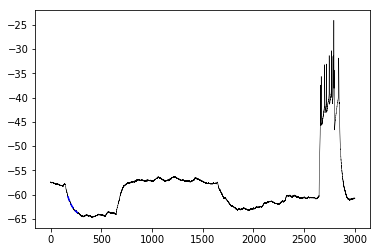

KeyboardInterrupt: 

In [8]:
ex_IA_pred = IASpikePredictor()
ex_IA_pred.add_recordings(ex_cell, (0, 100), (5000, 5100), tau=(1000, 1700, 2700))
ex_IA_pred.scrape_data(exclude_above=0)
ex_IA_pred.fit_spks()